In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams["figure.dpi"] = 1200
from lightkurve import search_lightcurve
from astropy.timeseries import LombScargle
# lk also has some nice periodogram abilities on its own, but here im primarily interested in it
# as a quick means of getting some data 

In [2]:
lc = search_lightcurve('KIC 10264202', author="Kepler", quarter=10, cadence="long").download().remove_nans()
times = np.array(lc.time.value)
fluxes = np.array(lc.flux)
flux_err = np.array(lc.flux_err)

Text(0.5, 1.0, 'Light Curve for KIC 10264202')

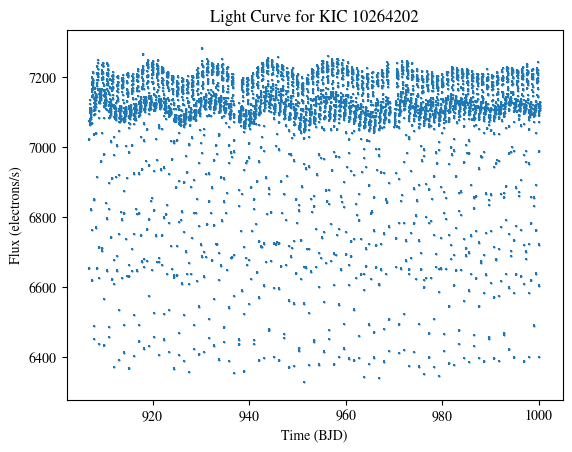

In [3]:
fig, ax = plt.subplots()
ax.errorbar(times, fluxes, yerr = flux_err, fmt = "o", markersize = 0.5) 
ax.set_ylabel("Flux (electrons/s)")
ax.set_xlabel("Time (BJD)")
ax.set_title("Light Curve for KIC 10264202")

In [4]:
frequency, power = LombScargle(times, fluxes, flux_err).autopower()

Text(0, 0.5, 'Normalized Power')

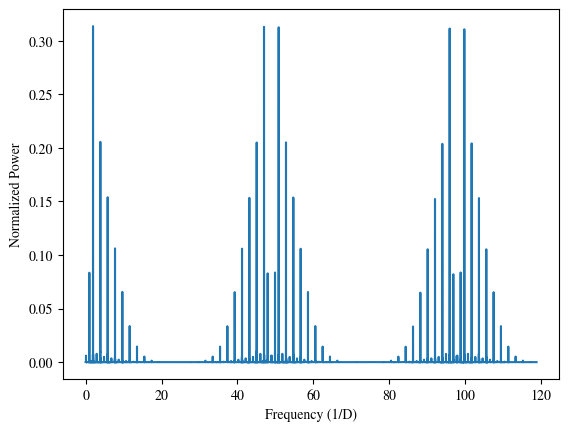

In [5]:
fig, ax = plt.subplots()
ax.plot(frequency, power) 
ax.set_xlabel("Frequency (1/D)")
ax.set_ylabel("Normalized Power")

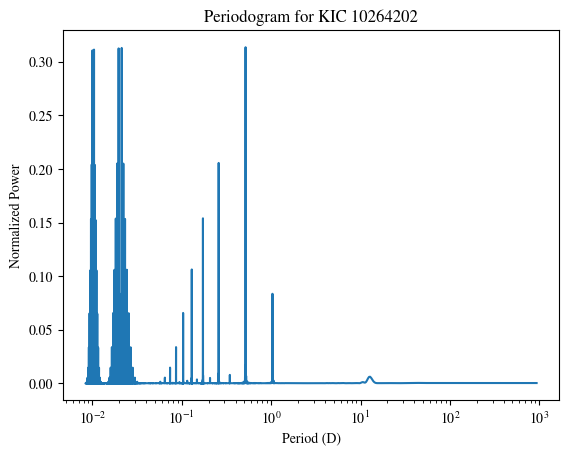

In [6]:
fig, ax = plt.subplots()
ax.plot(1/frequency, power)
ax.set_xlabel("Period (D)")
ax.set_ylabel("Normalized Power")
ax.set_title("Periodogram for KIC 10264202")
ax.set_xscale("log")

In [7]:
# lots of aliasing -- let's identify the peak and use phase folding to distinguish between harmonic candidates

period_at_max_power = 1/frequency[np.argmax(power)]

# phase plot function from our LSST notebooks 

def phase_plot(x, y, period, y_unc = 0.0, label_text = None):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the y 
    '''    
    phases = (x % period)/(period) * (2*np.pi)
    if type(y_unc) == float:
        y_unc = np.zeros_like(x)
        
    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1, label = label_text)
    ax.set_xlabel("Phase (Radians)")
    ax.set_ylabel("Signal")
    ax.set_title("Phase Folding")
    ax.legend()

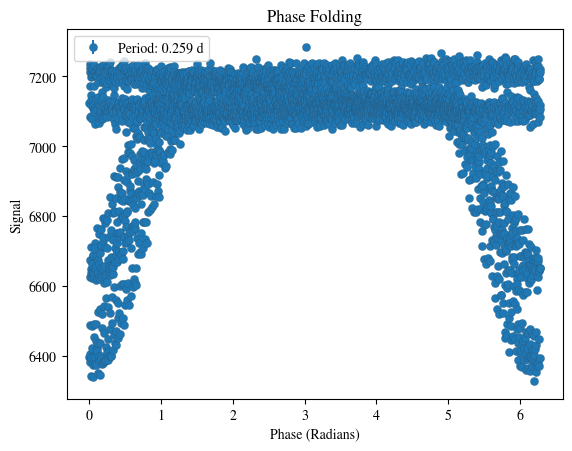

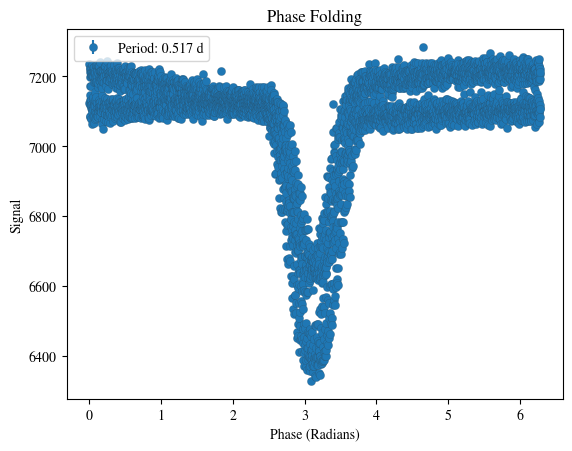

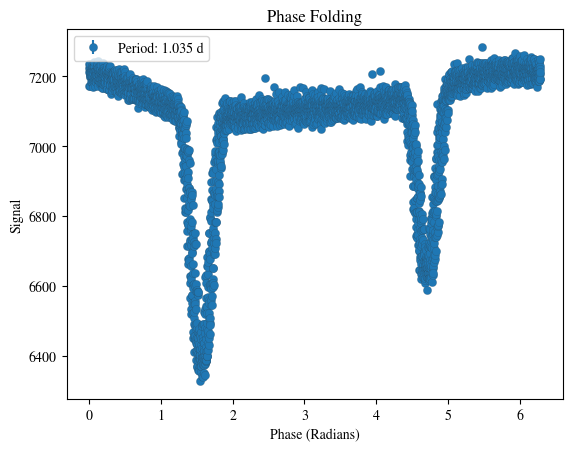

In [8]:
harmonic_candidates = [1/2 * period_at_max_power, period_at_max_power, 2 * period_at_max_power]
# maybe the one we found isn't the lowest -- hence the non-integer 1/2
for period in harmonic_candidates:
    phase_plot(times, fluxes, period, y_unc = flux_err, label_text = f"Period: {round(period, 3)} d")

Looks like the third one takes the cake, giving a period of

In [9]:
print(f"{2 * period_at_max_power} days")

1.034924642511494 days


This agrees with what the LightKurve tutorial found for this object.